In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

We will use the GPU: NVIDIA GeForce RTX 3060 Ti


In [2]:
#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

def deep_clean(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [41]:
df = pd.read_csv("./tweets_after_fight/2022-02-24.csv")

#Get the cleaned tweets
texts_new = []
i = 0
for t in df.text:
    i = i+1
    if i%100000==0:
        print(i)
    texts_new.append(deep_clean(t))
df['text_clean'] = texts_new
df.drop_duplicates("text_clean", inplace=True)
df = df.dropna()

print('Number of dataset sentences: {:,}\n'.format(df.shape[0]))
sentences = df.text_clean.values
df.head()

Number of dataset sentences: 23,923



,tweets_id,text,author_id,username,user_created_time,user_location,user_name,user_description,geo_place_id,geo_country_code,geo_place_type,geo_full_name,geo_bbox,geo_country,geo_name,date,text_clean
1,1465898587280318464,Still tryna figure out why &amp; how we got 10...,2238250956,dddro__,2013-12-09T22:44:32.000Z,Htx 📍,adrian⚜️,🇩🇴 | UPCOMING BARBER💈 hit my DM for bookings! ...,1c69a67ad480e1b1,US,city,"Houston, TX","[-95.823268, 29.522325, -95.069705, 30.1546646]",Etats-Unis,Houston,2021-12-01,still tryna figur amp got 10 ls season
2,1465898586479087629,@califorania @LilPapiFresh Thank you!!,1084172650883121152,MoBetterSB,2019-01-12T19:37:57.000Z,Mo Better Burgers South Bay,🏁Mo Better Burgers South Bay🏁,Great Home Style Burgers. MONDAY-SATURDAY FROM...,0f05fddc75546000,US,poi,Mo Better Burgers South Bay,"[-118.326203, 33.916671, -118.326203, 33.916671]",Etats-Unis,Mo Better Burgers South Bay,2021-12-01,thank
3,1465898584826527747,"someone pick a new name for me, i dont want th...",1167150558,albeeerrto,2013-02-10T22:04:48.000Z,"Isla Vista, CA",a!berto,ucsb | he/him ♍️♍️♒️,d82e2984d5b9a65e,US,city,"Isla Vista, CA","[-119.881745, 34.404565, -119.828412, 34.438713]",Etats-Unis,Isla Vista,2021-12-01,someon pick new name dont want one anymor
4,1465898584314834947,@transphem huggable,1387578601210454021,deermouse127477,2021-04-29T01:25:03.000Z,she he it cheese tme blkntv,quinn 🌈 ⚢,federally oppressed autistic girl microinfluen...,07d9e3e8d4884000,US,poi,Party World,"[-149.89866899999998, 61.185451, -149.89866899...",Etats-Unis,Party World,2021-12-01,huggabl
5,1465898581848641536,"Without downloading any new pics, where are yo...",1417685586530426881,LockDownRadio4,2021-07-21T03:19:30.000Z,"Mae Thot, Thailand",A CityBoy Named 🅿️im🅿️,"Podcast ""LockDownRadio"" coming in the fall FKA...",3df0e3eb1e91170b,US,city,"Columbus, OH","[-83.200169, 39.832013, -82.7713751, 40.157354]",Etats-Unis,Columbus,2021-12-01,without download new pic mental


In [5]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  put entir bovada balanc wolv tonight 25 timberwolv 3 last 27 game im 20 bet love free money
Tokenized:  ['put', 'en', '##ti', '##r', 'bo', '##va', '##da', 'bala', '##nc', 'wo', '##l', '##v', 'tonight', '25', 'timber', '##wo', '##l', '##v', '3', 'last', '27', 'game', 'im', '20', 'bet', 'love', 'free', 'money']
Token IDs:  [2404, 4372, 3775, 2099, 8945, 3567, 2850, 21451, 12273, 24185, 2140, 2615, 3892, 2423, 7227, 12155, 2140, 2615, 1017, 2197, 2676, 2208, 10047, 2322, 6655, 2293, 2489, 2769]


In [5]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  78


In [42]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 80,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

C:\Users\yizhe\.conda\envs\pytorch\lib\site-packages\transformers\tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [43]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  still tryna figur amp got 10 ls season
Token IDs: tensor([  101,  2145,  3046,  2532, 20965,  3126, 23713,  2288,  2184,  1048,
         2015,  2161,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


In [44]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

dataset = TensorDataset(input_ids, attention_masks)
batch_size = 32
dataloader = DataLoader(
            dataset,  
            batch_size = batch_size
        )


In [45]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    return_dict=False,
)

model.load_state_dict(torch.load("./model/BERT.pt"))
# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [46]:
# Put the model in evaluation mode--the dropout layers behave differently
# during evaluation.
model.eval()
labels = []
p_threshold = 0.9

for batch in dataloader:

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():        
        logits = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask)[0]
        p = nn.functional.softmax(logits, dim=1)
        p = p.detach().cpu().numpy()
        
        # 0 for negative， 1 for positive, 2 for neutral
        for line in p:
            if line[0] > p_threshold:
                labels.append(0)
            elif line[1] > p_threshold:
                labels.append(1)
            else:
                labels.append(2)

In [47]:
print(len(df))
print(len(sentences))
print(len(labels))

23923
23923
23923


In [48]:
df['classification_labels'] = labels
df.head()

,tweets_id,text,author_id,username,user_created_time,user_location,user_name,user_description,geo_place_id,geo_country_code,geo_place_type,geo_full_name,geo_bbox,geo_country,geo_name,date,text_clean,classification_labels
1,1465898587280318464,Still tryna figure out why &amp; how we got 10...,2238250956,dddro__,2013-12-09T22:44:32.000Z,Htx 📍,adrian⚜️,🇩🇴 | UPCOMING BARBER💈 hit my DM for bookings! ...,1c69a67ad480e1b1,US,city,"Houston, TX","[-95.823268, 29.522325, -95.069705, 30.1546646]",Etats-Unis,Houston,2021-12-01,still tryna figur amp got 10 ls season,2
2,1465898586479087629,@califorania @LilPapiFresh Thank you!!,1084172650883121152,MoBetterSB,2019-01-12T19:37:57.000Z,Mo Better Burgers South Bay,🏁Mo Better Burgers South Bay🏁,Great Home Style Burgers. MONDAY-SATURDAY FROM...,0f05fddc75546000,US,poi,Mo Better Burgers South Bay,"[-118.326203, 33.916671, -118.326203, 33.916671]",Etats-Unis,Mo Better Burgers South Bay,2021-12-01,thank,2
3,1465898584826527747,"someone pick a new name for me, i dont want th...",1167150558,albeeerrto,2013-02-10T22:04:48.000Z,"Isla Vista, CA",a!berto,ucsb | he/him ♍️♍️♒️,d82e2984d5b9a65e,US,city,"Isla Vista, CA","[-119.881745, 34.404565, -119.828412, 34.438713]",Etats-Unis,Isla Vista,2021-12-01,someon pick new name dont want one anymor,0
4,1465898584314834947,@transphem huggable,1387578601210454021,deermouse127477,2021-04-29T01:25:03.000Z,she he it cheese tme blkntv,quinn 🌈 ⚢,federally oppressed autistic girl microinfluen...,07d9e3e8d4884000,US,poi,Party World,"[-149.89866899999998, 61.185451, -149.89866899...",Etats-Unis,Party World,2021-12-01,huggabl,2
5,1465898581848641536,"Without downloading any new pics, where are yo...",1417685586530426881,LockDownRadio4,2021-07-21T03:19:30.000Z,"Mae Thot, Thailand",A CityBoy Named 🅿️im🅿️,"Podcast ""LockDownRadio"" coming in the fall FKA...",3df0e3eb1e91170b,US,city,"Columbus, OH","[-83.200169, 39.832013, -82.7713751, 40.157354]",Etats-Unis,Columbus,2021-12-01,without download new pic mental,0


In [49]:
df.to_csv("./tweets_2021_labeled/2021_12__labeled.csv", encoding='utf-8')

In [7]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    return_dict=False,
)

model.load_state_dict(torch.load("./model/BERT.pt"))
# Tell pytorch to run this model on the GPU.
model.cuda()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
path = './model_show_sample_for_covid/after_covid'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_covid/after_covid/' + file)
    
    #Get the cleaned tweets
    texts_new = []
    i = 0
    for t in df.text:
        i = i+1
        if i%100000==0:
            print(i)
        texts_new.append(deep_clean(t))
    df['text_clean'] = texts_new
    df.drop_duplicates("text_clean", inplace=True)
    df = df.dropna()

    print('Number of dataset sentences: {:,}\n'.format(df.shape[0]))
    sentences = df.text_clean.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 80,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    dataset = TensorDataset(input_ids, attention_masks)
    batch_size = 32
    dataloader = DataLoader(
                dataset,  
                batch_size = batch_size
            )
    
    
    model.eval()
    labels = []
    p_threshold = 0.9

    for batch in dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            logits = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask)[0]
            p = nn.functional.softmax(logits, dim=1)
            p = p.detach().cpu().numpy()

            # 0 for negative， 1 for positive, 2 for neutral
            for line in p:
                if line[0] > p_threshold:
                    labels.append(0)
                elif line[1] > p_threshold:
                    labels.append(1)
                else:
                    labels.append(2)
    df['classification_labels'] = labels
    df.to_csv("./model_show_sample_for_covid_labeled/after_covid/"+file, encoding='utf-8')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Number of dataset sentences: 9,142

Number of dataset sentences: 9,111

Number of dataset sentences: 9,200

Number of dataset sentences: 9,173

Number of dataset sentences: 9,158

Number of dataset sentences: 9,234

Number of dataset sentences: 9,242



In [9]:
path = './model_show_sample_for_covid/before_covid'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_covid/before_covid/' + file)
    
    #Get the cleaned tweets
    texts_new = []
    i = 0
    for t in df.text:
        i = i+1
        if i%100000==0:
            print(i)
        texts_new.append(deep_clean(t))
    df['text_clean'] = texts_new
    df.drop_duplicates("text_clean", inplace=True)
    df = df.dropna()

    print('Number of dataset sentences: {:,}\n'.format(df.shape[0]))
    sentences = df.text_clean.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 80,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    dataset = TensorDataset(input_ids, attention_masks)
    batch_size = 32
    dataloader = DataLoader(
                dataset,  
                batch_size = batch_size
            )
    
    
    model.eval()
    labels = []
    p_threshold = 0.9

    for batch in dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            logits = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask)[0]
            p = nn.functional.softmax(logits, dim=1)
            p = p.detach().cpu().numpy()

            # 0 for negative， 1 for positive, 2 for neutral
            for line in p:
                if line[0] > p_threshold:
                    labels.append(0)
                elif line[1] > p_threshold:
                    labels.append(1)
                else:
                    labels.append(2)
    df['classification_labels'] = labels
    df.to_csv("./model_show_sample_for_covid_labeled/before_covid/"+file, encoding='utf-8')

Number of dataset sentences: 9,214

Number of dataset sentences: 9,265

Number of dataset sentences: 9,223

Number of dataset sentences: 9,237

Number of dataset sentences: 9,052

Number of dataset sentences: 9,209

Number of dataset sentences: 9,290



In [10]:
path = './model_show_sample_for_election/biden'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_election/biden/' + file)
    
    #Get the cleaned tweets
    texts_new = []
    i = 0
    for t in df.text:
        i = i+1
        if i%100000==0:
            print(i)
        texts_new.append(deep_clean(t))
    df['text_clean'] = texts_new
    df.drop_duplicates("text_clean", inplace=True)
    df = df.dropna()

    print('Number of dataset sentences: {:,}\n'.format(df.shape[0]))
    sentences = df.text_clean.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 80,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    dataset = TensorDataset(input_ids, attention_masks)
    batch_size = 32
    dataloader = DataLoader(
                dataset,  
                batch_size = batch_size
            )
    
    
    model.eval()
    labels = []
    p_threshold = 0.9

    for batch in dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            logits = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask)[0]
            p = nn.functional.softmax(logits, dim=1)
            p = p.detach().cpu().numpy()

            # 0 for negative， 1 for positive, 2 for neutral
            for line in p:
                if line[0] > p_threshold:
                    labels.append(0)
                elif line[1] > p_threshold:
                    labels.append(1)
                else:
                    labels.append(2)
    df['classification_labels'] = labels
    df.to_csv("./model_show_sample_for_election_labeled/biden/"+file, encoding='utf-8')

Number of dataset sentences: 878

Number of dataset sentences: 680

Number of dataset sentences: 633

Number of dataset sentences: 605

Number of dataset sentences: 484

Number of dataset sentences: 512

Number of dataset sentences: 472



In [11]:
path = './model_show_sample_for_election/trump'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_election/trump/' + file)
    
    #Get the cleaned tweets
    texts_new = []
    i = 0
    for t in df.text:
        i = i+1
        if i%100000==0:
            print(i)
        texts_new.append(deep_clean(t))
    df['text_clean'] = texts_new
    df.drop_duplicates("text_clean", inplace=True)
    df = df.dropna()

    print('Number of dataset sentences: {:,}\n'.format(df.shape[0]))
    sentences = df.text_clean.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 80,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    dataset = TensorDataset(input_ids, attention_masks)
    batch_size = 32
    dataloader = DataLoader(
                dataset,  
                batch_size = batch_size
            )
    
    
    model.eval()
    labels = []
    p_threshold = 0.9

    for batch in dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            logits = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask)[0]
            p = nn.functional.softmax(logits, dim=1)
            p = p.detach().cpu().numpy()

            # 0 for negative， 1 for positive, 2 for neutral
            for line in p:
                if line[0] > p_threshold:
                    labels.append(0)
                elif line[1] > p_threshold:
                    labels.append(1)
                else:
                    labels.append(2)
    df['classification_labels'] = labels
    df.to_csv("./model_show_sample_for_election_labeled/trump/"+file, encoding='utf-8')

Number of dataset sentences: 590

Number of dataset sentences: 511

Number of dataset sentences: 605

Number of dataset sentences: 541

Number of dataset sentences: 390

Number of dataset sentences: 345

Number of dataset sentences: 375



In [14]:
path = './model_show_sample_for_war/holiday_week'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_war/holiday_week/' + file)
    
    #Get the cleaned tweets
    texts_new = []
    i = 0
    for t in df.text:
        i = i+1
        if i%100000==0:
            print(i)
        texts_new.append(deep_clean(t))
    df['text_clean'] = texts_new
    df.drop_duplicates("text_clean", inplace=True)
    df = df.dropna()

    print('Number of dataset sentences: {:,}\n'.format(df.shape[0]))
    sentences = df.text_clean.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 80,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    dataset = TensorDataset(input_ids, attention_masks)
    batch_size = 32
    dataloader = DataLoader(
                dataset,  
                batch_size = batch_size
            )
    
    
    model.eval()
    labels = []
    p_threshold = 0.9

    for batch in dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            logits = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask)[0]
            p = nn.functional.softmax(logits, dim=1)
            p = p.detach().cpu().numpy()

            # 0 for negative， 1 for positive, 2 for neutral
            for line in p:
                if line[0] > p_threshold:
                    labels.append(0)
                elif line[1] > p_threshold:
                    labels.append(1)
                else:
                    labels.append(2)
    df['classification_labels'] = labels
    df.to_csv("./model_show_sample_for_war_labeled/holiday_week/"+file, encoding='utf-8')

Number of dataset sentences: 9,318

Number of dataset sentences: 9,344

Number of dataset sentences: 9,475

Number of dataset sentences: 9,462

Number of dataset sentences: 9,470

Number of dataset sentences: 9,479

Number of dataset sentences: 9,430



In [15]:
path = './model_show_sample_for_war/normal_week'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_war/normal_week/' + file)
    
    #Get the cleaned tweets
    texts_new = []
    i = 0
    for t in df.text:
        i = i+1
        if i%100000==0:
            print(i)
        texts_new.append(deep_clean(t))
    df['text_clean'] = texts_new
    df.drop_duplicates("text_clean", inplace=True)
    df = df.dropna()

    print('Number of dataset sentences: {:,}\n'.format(df.shape[0]))
    sentences = df.text_clean.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 80,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    dataset = TensorDataset(input_ids, attention_masks)
    batch_size = 32
    dataloader = DataLoader(
                dataset,  
                batch_size = batch_size
            )
    
    
    model.eval()
    labels = []
    p_threshold = 0.9

    for batch in dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            logits = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask)[0]
            p = nn.functional.softmax(logits, dim=1)
            p = p.detach().cpu().numpy()

            # 0 for negative， 1 for positive, 2 for neutral
            for line in p:
                if line[0] > p_threshold:
                    labels.append(0)
                elif line[1] > p_threshold:
                    labels.append(1)
                else:
                    labels.append(2)
    df['classification_labels'] = labels
    df.to_csv("./model_show_sample_for_war_labeled/normal_week/"+file, encoding='utf-8')

Number of dataset sentences: 9,604

Number of dataset sentences: 9,518

Number of dataset sentences: 9,447

Number of dataset sentences: 9,443

Number of dataset sentences: 9,475

Number of dataset sentences: 9,484

Number of dataset sentences: 9,440



In [16]:
path = './model_show_sample_for_war/war_week'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_war/war_week/' + file)
    
    #Get the cleaned tweets
    texts_new = []
    i = 0
    for t in df.text:
        i = i+1
        if i%100000==0:
            print(i)
        texts_new.append(deep_clean(t))
    df['text_clean'] = texts_new
    df.drop_duplicates("text_clean", inplace=True)
    df = df.dropna()

    print('Number of dataset sentences: {:,}\n'.format(df.shape[0]))
    sentences = df.text_clean.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 80,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
        
    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    
    dataset = TensorDataset(input_ids, attention_masks)
    batch_size = 32
    dataloader = DataLoader(
                dataset,  
                batch_size = batch_size
            )
    
    
    model.eval()
    labels = []
    p_threshold = 0.9

    for batch in dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            logits = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask)[0]
            p = nn.functional.softmax(logits, dim=1)
            p = p.detach().cpu().numpy()

            # 0 for negative， 1 for positive, 2 for neutral
            for line in p:
                if line[0] > p_threshold:
                    labels.append(0)
                elif line[1] > p_threshold:
                    labels.append(1)
                else:
                    labels.append(2)
    df['classification_labels'] = labels
    df.to_csv("./model_show_sample_for_war_labeled/war_week/"+file, encoding='utf-8')

Number of dataset sentences: 9,215

Number of dataset sentences: 9,196

Number of dataset sentences: 9,155

Number of dataset sentences: 9,173

Number of dataset sentences: 9,211

Number of dataset sentences: 9,187

Number of dataset sentences: 9,163



In [ ]:
import pandas as pd
import json
import random
import re
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
import pandas as pd
import json
import random
import re
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
path = './model_show_sample_for_covid_labeled/after_covid'
silhouette_scores = []
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_covid_labeled/after_covid/' + file)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df['cluster_labels'] = kmeans.labels_.tolist()
    silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
    print(silhouette_avg)
    silhouette_scores.append(silhouette_avg)
    df.to_csv("./model_show_sample_for_covid_labeled2/after_covid/"+file, encoding='utf-8')

0.016568989328035074
0.015613684247036479
0.016257885754444056
0.01705333751089712
0.017550504416775754
0.01725578662032316
0.017754472470615467


In [33]:
path = './model_show_sample_for_covid_labeled/after_covid'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_covid_labeled/after_covid/' + file)
    df_negative = df[df['classification_labels']==0]
    df_positive = df[df['classification_labels']==1]
    df_neutral = df[df['classification_labels']==2]
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==0, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==1, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_neutral.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==2, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    df.to_csv("./model_show_sample_for_covid_labeled2/after_covid/"+file, encoding='utf-8')

In [4]:
path = './model_show_sample_for_covid_labeled/before_covid'
silhouette_scores = []
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_covid_labeled/before_covid/' + file)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df['cluster_labels'] = kmeans.labels_.tolist()
    silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
    print(silhouette_avg)
    silhouette_scores.append(silhouette_avg)
    df.to_csv("./model_show_sample_for_covid_labeled2/before_covid/"+file, encoding='utf-8')

0.015138071297806503
0.017174697056760557
0.015824712668360823
0.015272081466749058
0.01445893711573941
0.014908305343165281
0.016062491329022016


In [34]:
path = './model_show_sample_for_covid_labeled/before_covid'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_covid_labeled/before_covid/' + file)
    df_negative = df[df['classification_labels']==0]
    df_positive = df[df['classification_labels']==1]
    df_neutral = df[df['classification_labels']==2]
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==0, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==1, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_neutral.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==2, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    df.to_csv("./model_show_sample_for_covid_labeled2/before_covid/"+file, encoding='utf-8')

In [6]:
path = './model_show_sample_for_election_labeled/biden'
silhouette_scores = []
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_election_labeled/biden/' + file)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df['cluster_labels'] = kmeans.labels_.tolist()
    silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
    print(silhouette_avg)
    silhouette_scores.append(silhouette_avg)
    df.to_csv("./model_show_sample_for_election_labeled2/biden/"+file, encoding='utf-8')

0.015075517341997734
0.009963492590062949
0.010533586113468326
0.012249278054137717
0.012061643877128662
0.016947366929415737
0.011927891496273314


In [35]:
path = './model_show_sample_for_election_labeled/biden'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_election_labeled/biden/' + file)
    df_negative = df[df['classification_labels']==0]
    df_positive = df[df['classification_labels']==1]
    df_neutral = df[df['classification_labels']==2]
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==0, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==1, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_neutral.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==2, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    df.to_csv("./model_show_sample_for_election_labeled2/biden/"+file, encoding='utf-8')

In [8]:
path = './model_show_sample_for_election_labeled/trump'
silhouette_scores = []
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_election_labeled/trump/' + file)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df['cluster_labels'] = kmeans.labels_.tolist()
    silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
    print(silhouette_avg)
    silhouette_scores.append(silhouette_avg)
    df.to_csv("./model_show_sample_for_election_labeled2/trump/"+file, encoding='utf-8')

0.011435546977161122
0.015030098534220462
0.00978908128682199
0.019080792199383228
0.021872474048372528
0.025036287204718927
0.018333472627322465


In [36]:
path = './model_show_sample_for_election_labeled/trump'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_election_labeled/trump/' + file)
    df_negative = df[df['classification_labels']==0]
    df_positive = df[df['classification_labels']==1]
    df_neutral = df[df['classification_labels']==2]
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==0, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==1, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_neutral.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==2, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    df.to_csv("./model_show_sample_for_election_labeled2/trump/"+file, encoding='utf-8')

In [11]:
path = './model_show_sample_for_war_labeled/holiday_week'
silhouette_scores = []
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_war_labeled/holiday_week/' + file)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df['cluster_labels'] = kmeans.labels_.tolist()
    silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
    print(silhouette_avg)
    silhouette_scores.append(silhouette_avg)
    df.to_csv("./model_show_sample_for_war_labeled2/holiday_week/"+file, encoding='utf-8')

0.01646405887681148
0.019513847925019204
0.018239600473125867
0.018440818359128384
0.018778837630010887
0.017849711963992043
0.017880696752746783


In [37]:
path = './model_show_sample_for_war_labeled/holiday_week'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_war_labeled/holiday_week/' + file)
    df_negative = df[df['classification_labels']==0]
    df_positive = df[df['classification_labels']==1]
    df_neutral = df[df['classification_labels']==2]
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==0, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==1, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_neutral.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==2, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    df.to_csv("./model_show_sample_for_war_labeled2/holiday_week/"+file, encoding='utf-8')

In [13]:
path = './model_show_sample_for_war_labeled/normal_week'
silhouette_scores = []
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_war_labeled/normal_week/' + file)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df['cluster_labels'] = kmeans.labels_.tolist()
    silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
    print(silhouette_avg)
    silhouette_scores.append(silhouette_avg)
    df.to_csv("./model_show_sample_for_war_labeled2/normal_week/"+file, encoding='utf-8')

0.017670683287918897
0.01740061736668546
0.017506809415156928
0.018150039884421973
0.01899363997951393
0.017534212281123177
0.01732684275877013


In [38]:
path = './model_show_sample_for_war_labeled/normal_week'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_war_labeled/normal_week/' + file)
    df_negative = df[df['classification_labels']==0]
    df_positive = df[df['classification_labels']==1]
    df_neutral = df[df['classification_labels']==2]
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==0, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==1, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_neutral.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==2, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    df.to_csv("./model_show_sample_for_war_labeled2/normal_week/"+file, encoding='utf-8')

In [15]:
path = './model_show_sample_for_war_labeled/war_week'
silhouette_scores = []
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_war_labeled/war_week/' + file)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df['cluster_labels'] = kmeans.labels_.tolist()
    silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
    print(silhouette_avg)
    silhouette_scores.append(silhouette_avg)
    df.to_csv("./model_show_sample_for_war_labeled2/war_week/"+file, encoding='utf-8')

0.017327936805183387
0.018343586176636277
0.01839409693873289
0.017264739226189506
0.018581506899765295
0.017276272088519503
0.018153934551241178


In [39]:
path = './model_show_sample_for_war_labeled/war_week'
for file in os.listdir(path):
    df = pd.read_csv('./model_show_sample_for_war_labeled/war_week/' + file)
    df_negative = df[df['classification_labels']==0]
    df_positive = df[df['classification_labels']==1]
    df_neutral = df[df['classification_labels']==2]
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==0, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==1, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_neutral.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==2, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    df.to_csv("./model_show_sample_for_war_labeled2/war_week/"+file, encoding='utf-8')

In [40]:
path = './tweets_2021_labeled/'
for file in os.listdir(path):
    df = pd.read_csv('./tweets_2021_labeled/' + file)
    df_negative = df[df['classification_labels']==0]
    df_positive = df[df['classification_labels']==1]
    df_neutral = df[df['classification_labels']==2]
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==0, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==1, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_neutral.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==2, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    df.to_csv("./tweets_2021_labeled2/"+file, encoding='utf-8')

In [41]:
path = './tweets_after_fight_labeled/'
for file in os.listdir(path):
    df = pd.read_csv('./tweets_after_fight_labeled/' + file)
    df_negative = df[df['classification_labels']==0]
    df_positive = df[df['classification_labels']==1]
    df_neutral = df[df['classification_labels']==2]
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==0, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==1, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf = tfidf_vectorizer.fit_transform(df_neutral.text_clean.values.astype('U'))
    tfidf = tfidf.toarray()
    kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
    df.loc[df['classification_labels']==2, 'sentiment_cluster'] = kmeans.labels_.tolist()
    
    df.to_csv("./tweets_after_fight_labeled2/"+file, encoding='utf-8')

In [25]:
df_full = pd.read_csv('./2022-02-24.csv')
df_negative = df_full[df_full['classification_labels']==0]
df_positive = df_full[df_full['classification_labels']==1]

Cluster number is  2 the score is  0.002079887051607737
Cluster number is  3 the score is  0.002574597378780764
Cluster number is  4 the score is  0.0031184233947970353
Cluster number is  5 the score is  0.004011688058412428
Cluster number is  6 the score is  0.0040365760242212735
Cluster number is  7 the score is  0.004924946239416343
Cluster number is  8 the score is  0.005428747970090698
Cluster number is  9 the score is  0.005439777440292466
Cluster number is  10 the score is  0.006218295680080144
Cluster number is  11 the score is  0.005856047498259905
Cluster number is  12 the score is  0.00784649174198867
Cluster number is  13 the score is  0.007311026316203147
Cluster number is  14 the score is  0.007971297103853121
Cluster number is  15 the score is  0.0076570560850095885
Cluster number is  16 the score is  0.00750907214845286
Cluster number is  17 the score is  0.008236270123541237
Cluster number is  18 the score is  0.008459849199693783
Cluster number is  19 the score is  0.

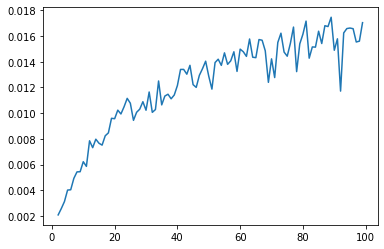

In [10]:
silhouette_scores_cluster = []
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
tfidf = tfidf.toarray()
for i in range(2,100):
    kmeans = KMeans(n_clusters=i, init='k-means++').fit(tfidf)
    silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
    silhouette_scores_cluster.append(silhouette_avg)
    print("Cluster number is ", i, "the score is ", silhouette_avg)
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(2, 100, 1)
plt.plot(x, silhouette_scores_cluster)
plt.show()

In [ ]:
silhouette_scores_cluster = []
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
tfidf = tfidf.toarray()
for i in range(2,100):
    kmeans = KMeans(n_clusters=i, init='k-means++').fit(tfidf)
    silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
    silhouette_scores_cluster.append(silhouette_avg)
    print("Cluster number is ", i, "the score is ", silhouette_avg)
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(2, 100, 1)
plt.plot(x, silhouette_scores_cluster)
plt.show()

In [12]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df_negative.text_clean.values.astype('U'))
tfidf = tfidf.toarray()
kmeans = KMeans(n_clusters=2, init='k-means++').fit(tfidf)
silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
print("Cluster number is ", 2, "the score is ", silhouette_avg)

Cluster number is  2 the score is  0.0020049824143745657


In [9]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df_positive.text_clean.values.astype('U'))
tfidf = tfidf.toarray()
kmeans = KMeans(n_clusters=60, init='k-means++').fit(tfidf)
silhouette_avg = silhouette_score(tfidf, kmeans.labels_)
print("Cluster number is ", 60, "the score is ", silhouette_avg)

Cluster number is  60 the score is  0.015145442818214812


In [20]:
df_full[df_full['classification_labels']==0]['negative_cluster'] = kmeans.labels_.astype(int)

C:\Users\yizhe\.conda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
df_full.loc[df_full['classification_labels']==0, 'negative'] = kmeans.labels_

In [29]:
kmeans.labels_.astype(int)

array([0, 0, 0, ..., 0, 0, 0])